In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os

# Load the dataset
df = pd.read_csv('Combined/FullCleaned.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort values by stock and date
df = df.sort_values(by=['Stock', 'Date'])

# Create the 'Next Year Date' column by adding 365 days to the current date
df['Next Year Date'] = df['Date'] + pd.DateOffset(days=365)

# Create the 'Next Year Price' column
df['Next Year Price'] = df.groupby('Stock')['Price'].shift(-4)

# Drop rows where 'Next Year Price' is NaN (i.e., last four quarters for each stock)
df = df.dropna(subset=['Next Year Price'])

# Specify the directory to save the file
output_directory = 'NextYear'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Save the standardized DataFrame to a new CSV file
output_file = os.path.join(output_directory, 'quarterly_reports_with_next_year_price.csv')
df.to_csv(output_file, index=False)

In [ ]:
import pandas as pd

# Function to process the stock data
def process_and_update_stock_data(input_csv, output_csv):
    # Read the input CSV file
    df = pd.read_csv(input_csv)
    
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the dataframe by 'Date' in descending order
    df = df.sort_values(by='Date', ascending=False)
    
    # Drop duplicates to get the latest date for each unique 'Stock'
    df_latest = df.drop_duplicates(subset='Stock', keep='first')
    
    # Save the latest records to the output CSV file
    df_latest.to_csv(output_csv, index=False)
    
    # Remove the latest records from the original dataframe
    df_remaining = df[~df.index.isin(df_latest.index)]
    
    # Save the remaining records back to the original CSV file
    df_remaining.to_csv(input_csv, index=False)


# Example usage
input_csv = 'NextYear/quarterly_reports_with_next_year_price.csv'
output_csv = 'NextYear/latest_stock_data.csv'
process_and_update_stock_data(input_csv, output_csv)


In [12]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the CSV file into a DataFrame
df = pd.read_csv('NextYear/NextYear.csv')

# Identify the numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Normalize all numerical columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Specify the directory to save the file
output_directory = 'NextYear/Z'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Save the scaler object
scaler_output_file = os.path.join(output_directory, 'scalerN.pkl')
joblib.dump(scaler, scaler_output_file)

# Save the normalized DataFrame to a new CSV file
output_file = os.path.join(output_directory, 'Normalized_DatasetZ.csv')
df.to_csv(output_file, index=False)

print("Normalization complete. The normalized data has been saved to 'Normalized_Dataset.csv' in the '{}' directory.".format(output_directory))
print("Scaler saved to '{}'.".format(scaler_output_file))


Normalization complete. The normalized data has been saved to 'Normalized_Dataset.csv' in the 'NextYear/Z' directory.
Scaler saved to 'NextYear/Z\scalerN.pkl'.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# # Load the dataset
df = pd.read_csv('NextYear/Z/Normalized_DatasetZ.csv')  # Replace with the path to your dataset

# Define features and target
features = ['Sales', 'Gross Income', 'EBIT', 'EBITDA', 'Net Income', 'Cash & Short-Term Investments',
            'Total Assets', 'Total Debt', 'Net Debt', 'Total Liabilities', 'Total Shareholders\' Equity',
            'Net Operating Cash Flow', 'Capital Expenditures', 'Net Investing Cash Flow', 'Net Financing Cash Flow',
            'Free Cash Flow', 'Long Term Debt Maturities']
target = 'Next Year Price'

# Prepare feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Standardize the features and the target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and the actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Load a new dataset
new_data = pd.read_csv('NextYear/latest_stock_data.csv')  # Replace with the path to your new dataset

# Ensure the new dataset has the same features
new_X = new_data[features]

# Standardize the new dataset
new_X_scaled = scaler_X.transform(new_X)

# Predict for the new dataset
new_pred_scaled = model.predict(new_X_scaled)

# Inverse transform the predictions to get the original scale
new_pred = scaler_y.inverse_transform(new_pred_scaled.reshape(-1, 1)).ravel()

# Add the predictions to the new dataset
new_data['Predicted Next Year Price'] = new_pred

# Print the results for all rows
print(new_data[['Stock', 'Price', 'Predicted Next Year Price']])


Root Mean Squared Error: 0.08011626235374956
    Stock       Price  Predicted Next Year Price
0      vw  125.757840                   0.381648
1    5380   15.007725                   0.427224
2    7202   13.094975                   0.371327
3      LI   21.300000                   0.272272
4    LCID    9.830000                   0.350415
5    RACE  226.613280                   0.371327
6      GM   40.430000                   0.386270
7    7261    7.886412                   0.311399
8   VOLVO   18.639770                   0.365980
9    7201    3.598911                   0.386270
10    PII  114.000000                   0.371327
11   7270   16.843230                   0.301633
12   7203   14.702421                   0.442185
13   7267    8.175768                   0.427224
14   7269   35.812553                   0.334283
15   RIVN   31.480000                   0.266232
16   Ford    1.524400                   0.329761
17    BMW   72.344020                   0.427224
18    MBG   54.648000   

In [71]:
import pickle
import numpy as np
import pandas as pd

# Assuming new_data is a DataFrame with the specified columns
# new_data = pd.DataFrame({
#     'Stock': ['AAPL', 'GOOGL'],
#     'Price': [150.0, 2700.0],
#     'Predicted Next Year Price': [160.0, 2800.0],
#     'Potential Return': [0.0667, 0.0370]  # This will be recalculated
# })

# Load the scaler object from file
scaler_file = 'NextYear/scaler.pkl'
with open(scaler_file, 'rb') as f:
    scaler = pickle.load(f)

# Extract the standardized "Predicted Next Year Price" column
predicted_next_year_price_standardized = new_data['Predicted Next Year Price']

# Construct a mock standardized data array with the correct shape
num_features = len(scaler.scale_)
standardized_data = np.zeros((len(new_data), num_features))

# Assuming "Predicted Next Year Price" is at the 18th index (replace this index as per your actual feature position)
index_for_predicted_price = 18
standardized_data[:, index_for_predicted_price] = predicted_next_year_price_standardized

# Inverse transform the standardized values
original_prices = scaler.inverse_transform(standardized_data)

# Extract the original "Predicted Next Year Price" values
new_data['Original Predicted Next Year Price'] = original_prices[:, index_for_predicted_price]

# Calculate the Potential Return
# Note: Ensure the standardized_data contains the correct transformed values
new_data['Potential Return'] = (new_data['Original Predicted Next Year Price'] / new_data['Price'] - 1) * 1000
new_data['Original Potential Return'] = (new_data['Next Year Price'] / new_data['Price'] - 1) * 1000

new_data['Fake Earninings'] = (new_data['Potential Return'] - new_data['Original Potential Return']) 



# Example of how to print all the relevant information
print(new_data[['Stock', 'Price', 'Predicted Next Year Price', 'Original Predicted Next Year Price', 'Potential Return','Next Year Price','Original Potential Return','Fake Earninings']])
print(new_data[[ 'Original Predicted Next Year Price', 'Next Year Price']])


    Stock       Price  Predicted Next Year Price  \
0      vw  125.757840                   1.817202   
1    5380   15.007725                   2.135070   
2    7202   13.094975                   1.825894   
3      LI   21.300000                   1.805854   
4    LCID    9.830000                   1.654027   
5    RACE  226.613280                   1.825894   
6      GM   40.430000                   1.852303   
7    7261    7.886412                   1.539396   
8   VOLVO   18.639770                   1.792895   
9    7201    3.598911                   1.852303   
10    PII  114.000000                   1.825894   
11   7270   16.843230                   1.773362   
12   7203   14.702421                   2.169911   
13   7267    8.175768                   2.135070   
14   7269   35.812553                   1.539903   
15   RIVN   31.480000                   1.782532   
16   Ford    1.524400                   1.463829   
17    BMW   72.344020                   2.135070   
18    MBG   

In [64]:
import os
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Function to standardize and save data
def standardize_and_save(input_file, output_directory):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Identify the numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Standardize all numerical columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Specify the directory to save the file
    os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the standardized DataFrame to a new CSV file
    output_file = os.path.join(output_directory, 'NextYearStand.csv')
    df.to_csv(output_file, index=False)

    # Save the scaler object using pickle
    scaler_file = os.path.join(output_directory, 'scalerL.pkl')
    with open(scaler_file, 'wb') as f:
        pickle.dump(scaler, f)

    # Print confirmation message
    print("Standardization complete. The standardized data has been saved to '.csv' and the scaler object to 'scaler.pkl' in the '{}' directory.".format(output_directory))

# Example usage:
if __name__ == "__main__":
    input_file = 'NextYear/NextYear.csv'
    output_directory = 'NextYear'
    standardize_and_save(input_file, output_directory)


Standardization complete. The standardized data has been saved to '.csv' and the scaler object to 'scaler.pkl' in the 'NextYear' directory.


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
df = pd.read_csv('NextYear/Z/Normalized_DatasetZ.csv')  # Replace with the path to your dataset

# Define features and target
features = ['Sales', 'Gross Income', 'EBIT', 'EBITDA', 'Net Income', 
            'Cash & Short-Term Investments', 'Total Assets', 'Total Debt', 
            'Net Debt', 'Total Liabilities', 'Total Shareholders\' Equity', 
            'Net Operating Cash Flow', 'Capital Expenditures', 'Net Investing Cash Flow', 
            'Net Financing Cash Flow', 'Free Cash Flow', 'Long Term Debt Maturities']
target = 'Next Year Price'

# Prepare feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Calculate RMSE from MSE
print(f'Root Mean Squared Error: {rmse}')

# Load a new dataset
new_data = pd.read_csv('NextYear/F/scaled_dataset.csv')  # Replace with the path to your new dataset

# Ensure the new dataset has the same features
new_X = new_data[features]

# Predict for the new dataset
new_pred = model.predict(new_X)

# Add the predictions to the new dataset
new_data['Predicted Next Year Price'] = new_pred

# Print the results for all rows
print(new_data[['Stock', 'Price', 'Predicted Next Year Price']])


Root Mean Squared Error: 0.08007011374865908
    Stock     Price  Predicted Next Year Price
0      vw  0.344426                   0.349322
1    5380  0.040948                   0.034125
2    7202  0.035706                   0.034171
3      LI  0.058190                   0.078413
4    LCID  0.026760                   0.057749
5      GM  0.110610                   0.138656
6    7261  0.021434                   0.030794
7   VOLVO  0.050900                   0.053621
8    7201  0.009685                   0.018623
9     PII  0.312207                   0.382583
10   7270  0.045977                   0.058464
11   7203  0.040111                   0.057949
12   7267  0.022227                   0.101610
13   7269  0.097957                   0.079585
14   RIVN  0.086085                   0.065268
15   Ford  0.004000                   0.022369
16    BMW  0.198061                   0.223601
17    MBG  0.149570                   0.209646
18  TESLA  0.759300                   0.474213
19   2333  0.00

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv('NextYear/Z/Normalized_DatasetZ.csv')  # Replace with the path to your dataset

# Define features and target
features = ['Sales', 'Gross Income', 'EBIT', 'EBITDA', 'Net Income', 
            'Cash & Short-Term Investments', 'Total Assets', 'Total Debt', 
            'Net Debt', 'Total Liabilities', 'Total Shareholders\' Equity', 
            'Net Operating Cash Flow', 'Capital Expenditures', 'Net Investing Cash Flow', 
            'Net Financing Cash Flow', 'Free Cash Flow', 'Long Term Debt Maturities']
target = 'Next Year Price'

# Prepare feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Calculate RMSE from MSE
print(f'Root Mean Squared Error: {rmse}')

# Load a new dataset
new_data = pd.read_csv('NextYear/F/scaled_dataset.csv')  # Replace with the path to your new dataset

# Ensure the new dataset has the same features
new_X = new_data[features]

# Predict for the new dataset
new_pred = model.predict(new_X)

# Add the predictions to the new dataset
new_data['Predicted Next Year Price'] = new_pred

# Print the results for all rows
print(new_data[['Stock', 'Price', 'Predicted Next Year Price']])


Root Mean Squared Error: 0.0556124284953082
    Stock     Price  Predicted Next Year Price
0      vw  0.344426                   0.360078
1    5380  0.040948                   0.030882
2    7202  0.035706                   0.059511
3      LI  0.058190                   0.072125
4    LCID  0.026760                   0.009485
5      GM  0.110610                   0.112488
6    7261  0.021434                   0.019497
7   VOLVO  0.050900                   0.055451
8    7201  0.009685                   0.015163
9     PII  0.312207                   0.315639
10   7270  0.045977                   0.048598
11   7203  0.040111                   0.104264
12   7267  0.022227                   0.034789
13   7269  0.097957                   0.097859
14   RIVN  0.086085                   0.047537
15   Ford  0.004000                   0.004770
16    BMW  0.198061                   0.213348
17    MBG  0.149570                   0.220621
18  TESLA  0.759300                   0.621146
19   2333  0.004

In [48]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Assuming new_data is a DataFrame with the specified columns
# new_data = pd.DataFrame({
#     'Stock': ['AAPL', 'GOOGL'],
#     'Price': [150.0, 2700.0],
#     'Predicted Next Year Price': [160.0, 2800.0],
#     'Potential Return': [0.0667, 0.0370]  # This will be recalculated
# })
df = pd.read_csv('NextYear/F/latest_stock_dataZ.csv')  # Replace with the path to your dataset



# # Assuming 'scaler' is your MinMaxScaler object
# scaler_file = 'NextYear/F/scaler.pkl'
# # with open(scaler_file, 'wb') as f:
# #     pickle.dump(scaler, f)

# scaler = joblib.load(scaler_file)


scaler = joblib.load('NextYear/Z/scaler.pkl')  # Adjust the path as necessary

# Extract the standardized "Predicted Next Year Price" column
predicted_next_year_price_standardized = new_data['Predicted Next Year Price']

# Construct a mock standardized data array with the correct shape
num_features = len(scaler.scale_)
standardized_data = np.zeros((len(new_data), num_features))

# Assuming "Predicted Next Year Price" is at the 18th index (replace this index as per your actual feature position)
index_for_predicted_price = 18
standardized_data[:, index_for_predicted_price] = predicted_next_year_price_standardized

# Inverse transform the standardized values
original_prices = scaler.inverse_transform(standardized_data)

# Extract the original "Predicted Next Year Price" values
new_data['Original Predicted Next Year Price'] = original_prices[:, index_for_predicted_price]

# Calculate the Potential Return
# Note: Ensure the standardized_data contains the correct transformed values
new_data['Potential Return'] = (new_data['Original Predicted Next Year Price'] / df['Price'] - 1) * 1000
new_data['Original Potential Return'] = (df['Next Year Price'] / df['Price'] - 1) * 1000

new_data['Squared Error'] = (new_data['Original Predicted Next Year Price'] - df['Next Year Price']) 
new_data['Ration'] = (df['Next Year Price'] / df['Price'] - 1) 
new_data['Ration Predicted'] = (new_data['Original Predicted Next Year Price'] / df['Price'] - 1) 
new_data['Next Year Prices'] = df['Next Year Price']
new_data['Prices'] = df['Price']

new_data['RationChange'] = df['Next Year Price']-df['Price']
new_data['RationChangePred'] = new_data['Original Predicted Next Year Price']-df['Price']


mse = new_data['Squared Error'].mean()

print(mse)

print(new_data[[ 'Stock', 'Prices','Next Year Prices','Original Predicted Next Year Price','Squared Error']])



# Example of how to print all the relevant information
print(new_data[['Stock','Potential Return','Original Potential Return']])


print(new_data[['Stock','Ration','Ration Predicted']])
print(new_data[['Stock','RationChange','RationChangePred']])




3.2136340332919833
    Stock      Prices  Next Year Prices  Original Predicted Next Year Price  \
0      vw  125.757840        115.961520                          131.557347   
1    5380   15.007725         11.214953                           11.466962   
2    7202   13.094975         13.104429                           21.910919   
3      LI   21.300000         36.300000                           26.512520   
4    LCID    9.830000          4.330000                            3.661412   
5      GM   40.430000         32.360000                           41.236812   
6    7261    7.886412         10.845862                            7.313616   
7   VOLVO   18.639770         23.466492                           20.429858   
8    7201    3.598911          3.971963                            5.732675   
9     PII  114.000000         87.410000                          115.345854   
10   7270   16.843230         18.017744                           17.929845   
11   7203   14.702421         19.

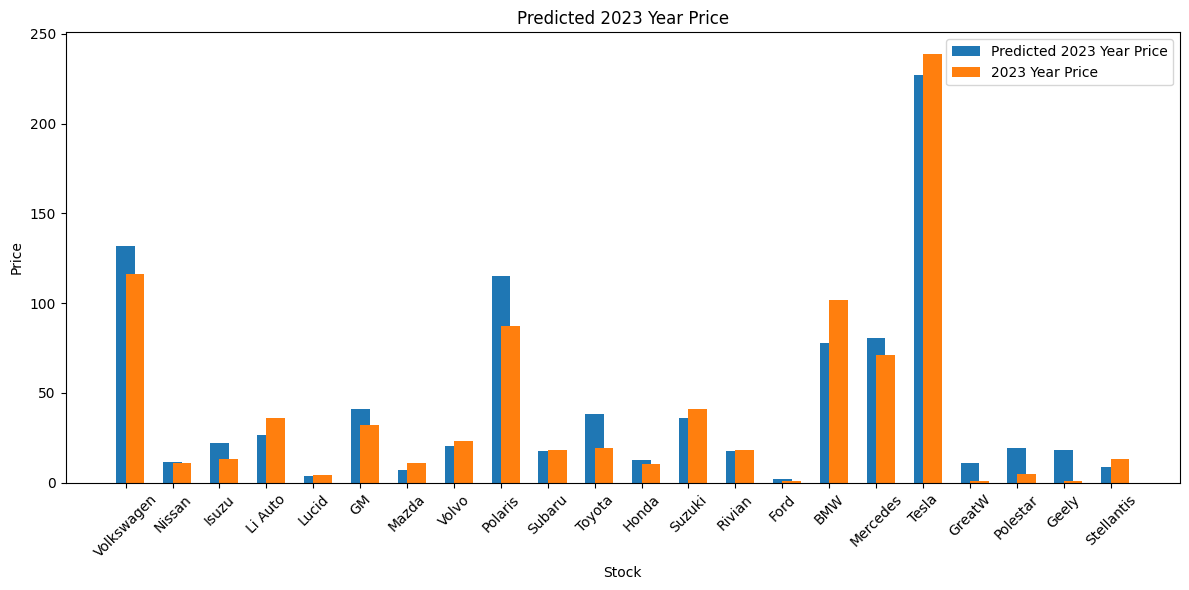

    Stock  Original Predicted Next Year Price  Next Year Prices
0      vw                          131.557347        115.961520
1    5380                           11.466962         11.214953
2    7202                           21.910919         13.104429
3      LI                           26.512520         36.300000
4    LCID                            3.661412          4.330000
5      GM                           41.236812         32.360000
6    7261                            7.313616         10.845862
7   VOLVO                           20.429858         23.466492
8    7201                            5.732675          3.971963
9     PII                          115.345854         87.410000
10   7270                           17.929845         18.017744
11   7203                           38.236771         19.185966
12   7267                           12.892073         10.358255
13   7269                           35.899992         41.026684
14   RIVN                           17.5

In [49]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# Plotting Potential Return vs Original Potential Return
plt.figure(figsize=(12, 6))
plt.bar(df['Stock'], new_data['Original Predicted Next Year Price'], width=0.4, align='center', label='Predicted 2023 Year Price')
plt.bar(df['Stock'], new_data['Next Year Prices'], width=0.4, align='edge', label='2023 Year Price')

plt.xlabel('Stock')
plt.ylabel('Price')
plt.title('Predicted 2023 Year Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()

# Print relevant information if needed
print(new_data[['Stock', 'Original Predicted Next Year Price','Next Year Prices']])


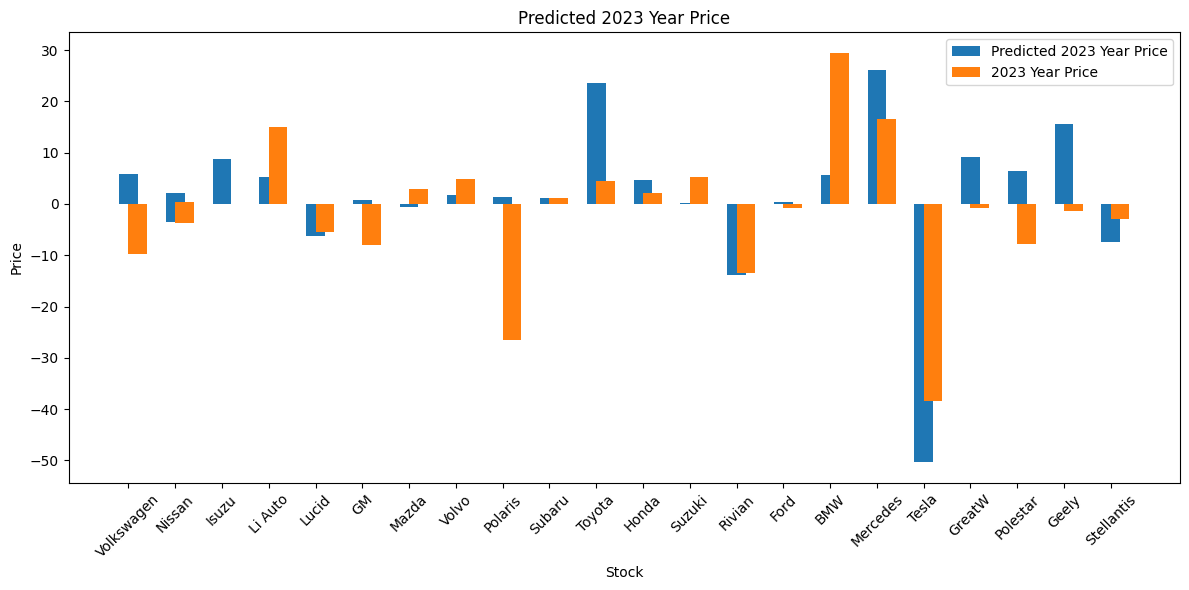

    Stock  Original Predicted Next Year Price  Next Year Prices
0      vw                          131.557347        115.961520
1    5380                           11.466962         11.214953
2    7202                           21.910919         13.104429
3      LI                           26.512520         36.300000
4    LCID                            3.661412          4.330000
5      GM                           41.236812         32.360000
6    7261                            7.313616         10.845862
7   VOLVO                           20.429858         23.466492
8    7201                            5.732675          3.971963
9     PII                          115.345854         87.410000
10   7270                           17.929845         18.017744
11   7203                           38.236771         19.185966
12   7267                           12.892073         10.358255
13   7269                           35.899992         41.026684
14   RIVN                           17.5

In [50]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# Plotting Potential Return vs Original Potential Return
plt.figure(figsize=(12, 6))
plt.bar(df['Stock'], new_data['RationChangePred'], width=0.4, align='center', label='Predicted 2023 Year Price')
plt.bar(df['Stock'], new_data['RationChange'], width=0.4, align='edge', label='2023 Year Price')

plt.xlabel('Stock')
plt.ylabel('Price')
plt.title('Predicted 2023 Year Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()

# Print relevant information if needed
print(new_data[['Stock', 'Original Predicted Next Year Price','Next Year Prices']])


In [66]:
import pickle
import pandas as pd




import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler  # Adjust scaler as per your original training

# Step 1: Load the scaler object from scalerL.pkl
with open('NextYear/scalerL.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Step 2: Load the input CSV file
input_csv = 'NextYear/latest_stock_data.csv'
data = pd.read_csv(input_csv)

# Step 3: Identify numerical columns and apply scaler only to those columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = scaler.transform(data[numerical_cols])

# Step 4: Save the scaled data to a new CSV file
output_csv = 'NextYear/scaled_data_output.csv'
data.to_csv(output_csv, index=False)

print(f"Scaled data saved to {output_csv}")



Scaled data saved to NextYear/scaled_data_output.csv


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib  # Use this import statement

# Load data from CSV
df = pd.read_csv('NextYear/NextYear.csv')

# Extract numeric columns for normalization
numeric_cols = df.select_dtypes(include=['number']).columns
data = df[numeric_cols].values

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler to the data and transform it
normalized_data = scaler.fit_transform(data)

# Save the scaler for future use
joblib.dump(scaler, 'NextYear/F/scaler.pkl')  # Save scaler to file 'scaler.pkl'

# Optionally, save the normalized data to a new CSV file
normalized_df = pd.DataFrame(normalized_data, columns=numeric_cols)
normalized_df.to_csv('NextYear/F/normalized_data.csv', index=False)

# If you need to load the scaler later, you can use:
# scaler = joblib.load('NextYear/F/scaler.pkl')


In [57]:
import pandas as pd
import joblib

# Load the saved scaler
scaler = joblib.load('NextYear/F/scaler.pkl')  # Adjust the path as necessary

# Example normalized value
normalized_value = 0.115484854

# Reshape the normalized_value appropriately for inverse_transform
normalized_value_reshaped = [[normalized_value] * 19]  # Shape should match the number of features in your data

# Inverse transform to get original value
original_value = scaler.inverse_transform(normalized_value_reshaped)

print("Original value in column 'Price':", original_value[0, 18])


Original value in column 'Price': 42.329999957452685


In [88]:
import joblib
import pandas as pd

# Load the scaler
scaler = joblib.load('NextYear/F/scaler.pkl')  # Adjust the path as necessary

# Load the new dataset
new_data = pd.read_csv('NextYear/F/latest_stock_data.csv')

# Identify numerical columns
numerical_columns = new_data.select_dtypes(include=['float64', 'int64']).columns

# Apply the scaler to numerical columns only
scaled_data = new_data.copy()
scaled_data[numerical_columns] = scaler.transform(new_data[numerical_columns])

# Save the scaled dataset
scaled_data.to_csv('NextYear/F/scaled_dataset.csv', index=False)


D:\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [2]:
import pandas as pd

# Dictionary mapping stock symbols to shorter common names
stock_mapping = {
    "TESLA": "Tesla",
    "7203": "Toyota",
    "RACE": "Ferrari",
    "STLAM": "Stellantis",
    "MBG": "Mercedes-Benz",
    "1211": "BYD",
    "vw": "Volkswagen",
    "BMW": "BMW",
    "7267": "Honda",
    "VOLVO": "Volvo",
    "Ford": "Ford",
    "5380": "Nissan",
    "GM": "GM",
    "LI": "Li Auto",
    "500520": "Mahindra",
    "2333": "Great Wall",
    "7269": "Suzuki",
    "7270": "Subaru",
    "RIVN": "Rivian",
    "7201": "Nissan",
    "VFS": "VinFast",
    "RNO": "Renault",
    "7202": "Isuzu",
    "175": "Geely",
    "NIO": "NIO",
    "LCID": "Lucid",
    "9868": "XPeng",
    "7261": "Mazda",
    "PII": "Polaris",
    "PSNY": "Polestar"
}

# Read the CSV file
input_file = "NextYear/F/latest_stock_data.csv"  # replace with your input file name
output_file = "NextYear/F/latest_stock_dataZ.csv"  # replace with your desired output file name
df = pd.read_csv(input_file)

# Convert stock symbols to shorter common names
df['Stock'] = df['Stock'].map(stock_mapping)

# Save the modified dataframe to a new CSV file
df.to_csv(output_file, index=False)

print(f"Converted stock symbols and saved the result to {output_file}")


Converted stock symbols and saved the result to NextYear/F/latest_stock_dataZ.csv
